In [25]:
from shapley_algorithms.benchmark import compute_attributions
from shapley_algorithms.benchmark import cache_train
from shapley_algorithms import data
from sklearn import datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost
import pickle
import os

# Load data
exp_name = 'blog'

if exp_name == 'diabetes':
    
    dataset = datasets.load_diabetes()
    X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
    y = dataset['target']
    
    def train_fn(X, y):
        return xgboost.XGBRegressor(n_estimators=10, max_depth=5).fit(X, y)
    
elif exp_name == 'diabetes_addl_features':
    
    dataset = datasets.load_diabetes()
    X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
    y = dataset['target']
    
    # Add dummy features
    for i in range(0, 100):
        X[f'dummy{i}'] = 0
    
    def train_fn(X, y):
        return xgboost.XGBRegressor(n_estimators=10, max_depth=5).fit(X, y)
    
elif exp_name == 'blog':
    
    exp_name = 'blog'
    X, y = data.blog()
    y = y.values

    def train_fn(X, y):
        return xgboost.XGBRegressor(n_estimators=100, max_depth=5).fit(X, y)
        
# Train model
cache_path = f'cache/{exp_name}/'
model = cache_train(train_fn, cache_path, X, y)

# Run benchmarking
num_evals_lst = [500, 1000, 5000, 10000, 50000, 100000]

if exp_name == 'blog':
    explicand = X.values[np.argsort(model.predict(X))[-10]] 
else:
    explicand = X.values[0]
    
baselines = X.values[1:2]
results = compute_attributions(
    model, num_evals_lst, explicand, baselines, X, y, cache_path,
    skip_methods=['ls_sgd', 'mef_rand']
)
exact_attribution, attributions, evals_counts, runtimes = results

Loading from cache: (500, 'mef')
Loading from cache: (1000, 'mef')
Loading from cache: (5000, 'mef')
Loading from cache: (10000, 'mef')
Loading from cache: (50000, 'mef')
Loading from cache: (100000, 'mef')
Skipping running from scratch: (500, 'mef_rand')
Skipping running from scratch: (1000, 'mef_rand')
Skipping running from scratch: (5000, 'mef_rand')
Skipping running from scratch: (10000, 'mef_rand')
Skipping running from scratch: (50000, 'mef_rand')
Skipping running from scratch: (100000, 'mef_rand')
Loading from cache: (500, 'mef_adapt')
Loading from cache: (1000, 'mef_adapt')
Loading from cache: (5000, 'mef_adapt')
Loading from cache: (10000, 'mef_adapt')
Loading from cache: (50000, 'mef_adapt')
Loading from cache: (100000, 'mef_adapt')
Loading from cache: (500, 'mef_anti')
Loading from cache: (1000, 'mef_anti')
Loading from cache: (5000, 'mef_anti')
Loading from cache: (10000, 'mef_anti')
Loading from cache: (50000, 'mef_anti')
Loading from cache: (100000, 'mef_anti')
Loading fr

In [26]:
from shapley_algorithms.utils import compute_variance
from shapley_algorithms.utils import compute_bias

biases = {num_evals: {} for num_evals in num_evals_lst}
variances = {num_evals: {} for num_evals in num_evals_lst}

for key, attribution in attributions.items():
    biases[key[0]][key[1]] = compute_bias(attribution, exact_attribution)
    variances[key[0]][key[1]] = compute_variance(attribution)
    
var_df = pd.DataFrame.from_dict(variances)
var_df

,500,1000,5000,10000,50000,100000
mef,0.000000e+00,8.933504e+04,4.330567e+03,2.375377e+03,5.425363e+02,264.142410
mef_adapt,0.000000e+00,0.000000e+00,3.851551e+02,3.915007e+02,8.538466e+01,40.684520
mef_anti,0.000000e+00,NaN,0.000000e+00,1.071564e+03,2.843915e+02,164.128704
rof,0.000000e+00,8.965402e+04,1.023468e+04,5.268767e+03,1.020955e+03,534.068208
rof_adapt,0.000000e+00,0.000000e+00,2.479704e+03,6.797336e+02,1.159888e+02,57.757363
rof_anti,0.000000e+00,NaN,3.914764e+03,1.797941e+03,3.393826e+02,162.715615
ro,9.072293e+04,3.163972e+04,5.028475e+03,2.659613e+03,5.963539e+02,245.732874
ro_anti,NaN,1.464927e+04,1.965697e+03,8.862359e+02,1.593758e+02,79.434533
ls,3.984836e+05,1.428070e+05,2.222079e+04,1.060086e+04,2.062526e+03,1032.159556
ls_anti,5.410153e+08,1.437492e+04,1.777132e+03,8.199275e+02,1.577530e+02,76.681778


divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10
divide by zero encountered in log10


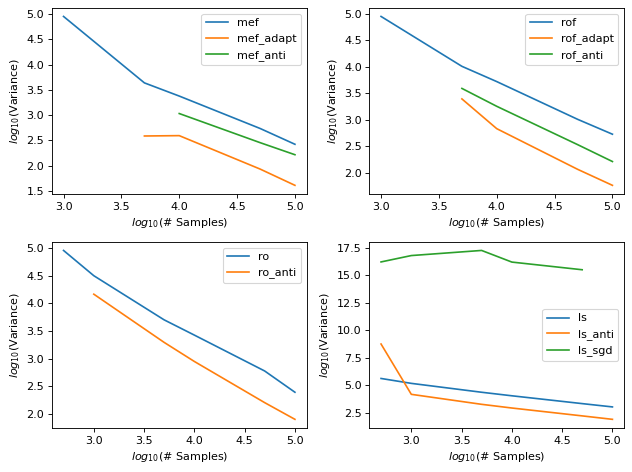

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
base_methods = ['mef', 'rof', 'ro', 'ls']

for i, base_method in enumerate(base_methods):
    plt.subplot(2, 2, i+1)
    for index, row in var_df.iterrows():

        if index == base_method or index.split('_')[0] == base_method:
            plt.plot(np.log10(num_evals_lst), np.log10(row), label=index)

    plt.legend()
    plt.xlabel("$log_{10}$(# Samples)")
    plt.ylabel("$log_{10}$(Variance)")

plt.tight_layout()
plt.show()

divide by zero encountered in log10
divide by zero encountered in log10


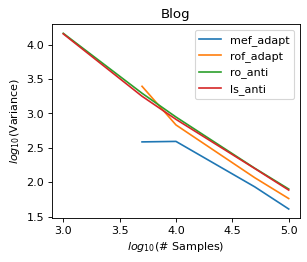

In [29]:
figure(figsize=(4, 3.2), dpi=80)

indices = ['mef_adapt', 'rof_adapt', 'ro_anti', 'ls_anti']

for index, row in var_df.iterrows():

    if index in indices:
        
        plt.plot(np.log10(num_evals_lst)[1:], np.log10(row)[1:], label=index)

plt.legend()
plt.xlabel("$log_{10}$(# Samples)")
plt.ylabel("$log_{10}$(Variance)")
plt.title('Blog')
plt.savefig(cache_path + 'variance.pdf')
plt.show()